In [ ]:
Automated Daily Deal with Special Client and without email client and without file movement 


Sheet Name: Bulk Block Deals
+----------------------------------------------+------------+--------------------------------------------------+----------+-----------+----------+---------------------+---------------+------------+----------+-------------------+-----------+
|                    Stock                     |    Code    |                   Client Name                    | Exchange | Deal Type |  Action  |        Date         | Average Price |  Quantity  | Traded % | Last Traded Price | File Date |
+----------------------------------------------+------------+--------------------------------------------------+----------+-----------+----------+---------------------+---------------+------------+----------+-------------------+-----------+
|             Ashoka Buildcon Ltd.             |   ASHOKA   |          GRAVITON RESEARCH CAPITAL LLP           |   NSE    |   Bulk    |   Sell   | 2024-01-09 00:00:00 |    157.07     | 2899236.0  |  1.0328  |      161.85       | 20240109  |
|     

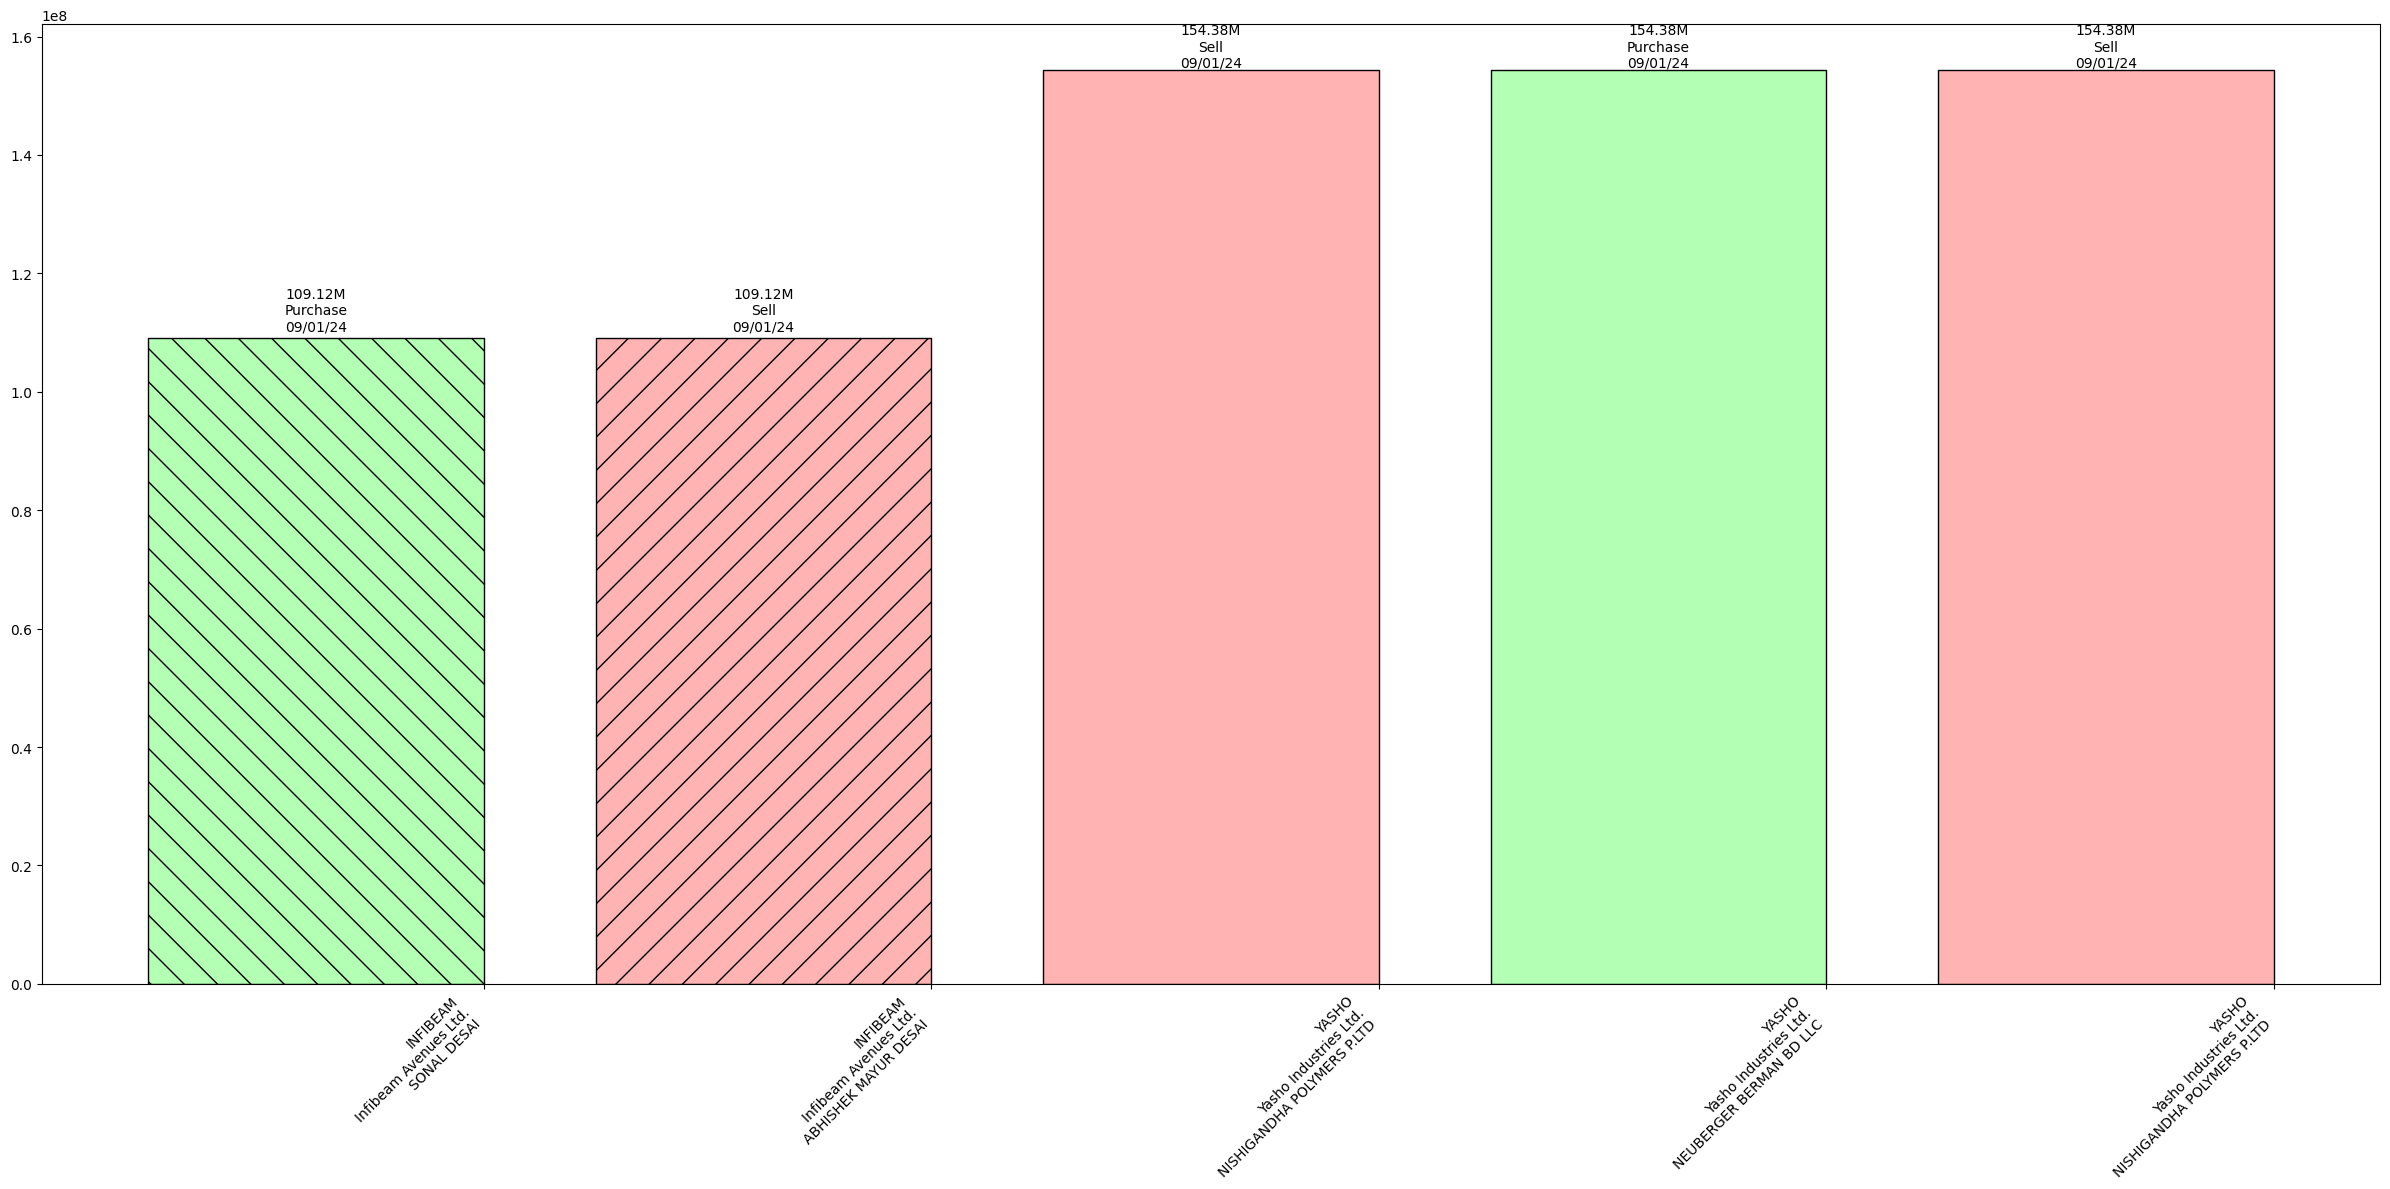


Special Clients:
Only Buy or Sell:
+-----------------------+-------+-------------------------+----------+-----------+----------+---------------------+---------------+----------+----------+-------------------+-----------+-------------+
|         Stock         | Code  |       Client Name       | Exchange | Deal Type |  Action  |        Date         | Average Price | Quantity | Traded % | Last Traded Price | File Date |   Amount    |
+-----------------------+-------+-------------------------+----------+-----------+----------+---------------------+---------------+----------+----------+-------------------+-----------+-------------+
| Yasho Industries Ltd. | YASHO | NEUBERGER BERMAN BD LLC |   NSE    |   Block   | Purchase | 2024-01-09 00:00:00 |    1625.0     | 95000.0  |  0.8334  |      1638.9       | 20240109  | 154375000.0 |
+-----------------------+-------+-------------------------+----------+-----------+----------+---------------------+---------------+----------+----------+-----------

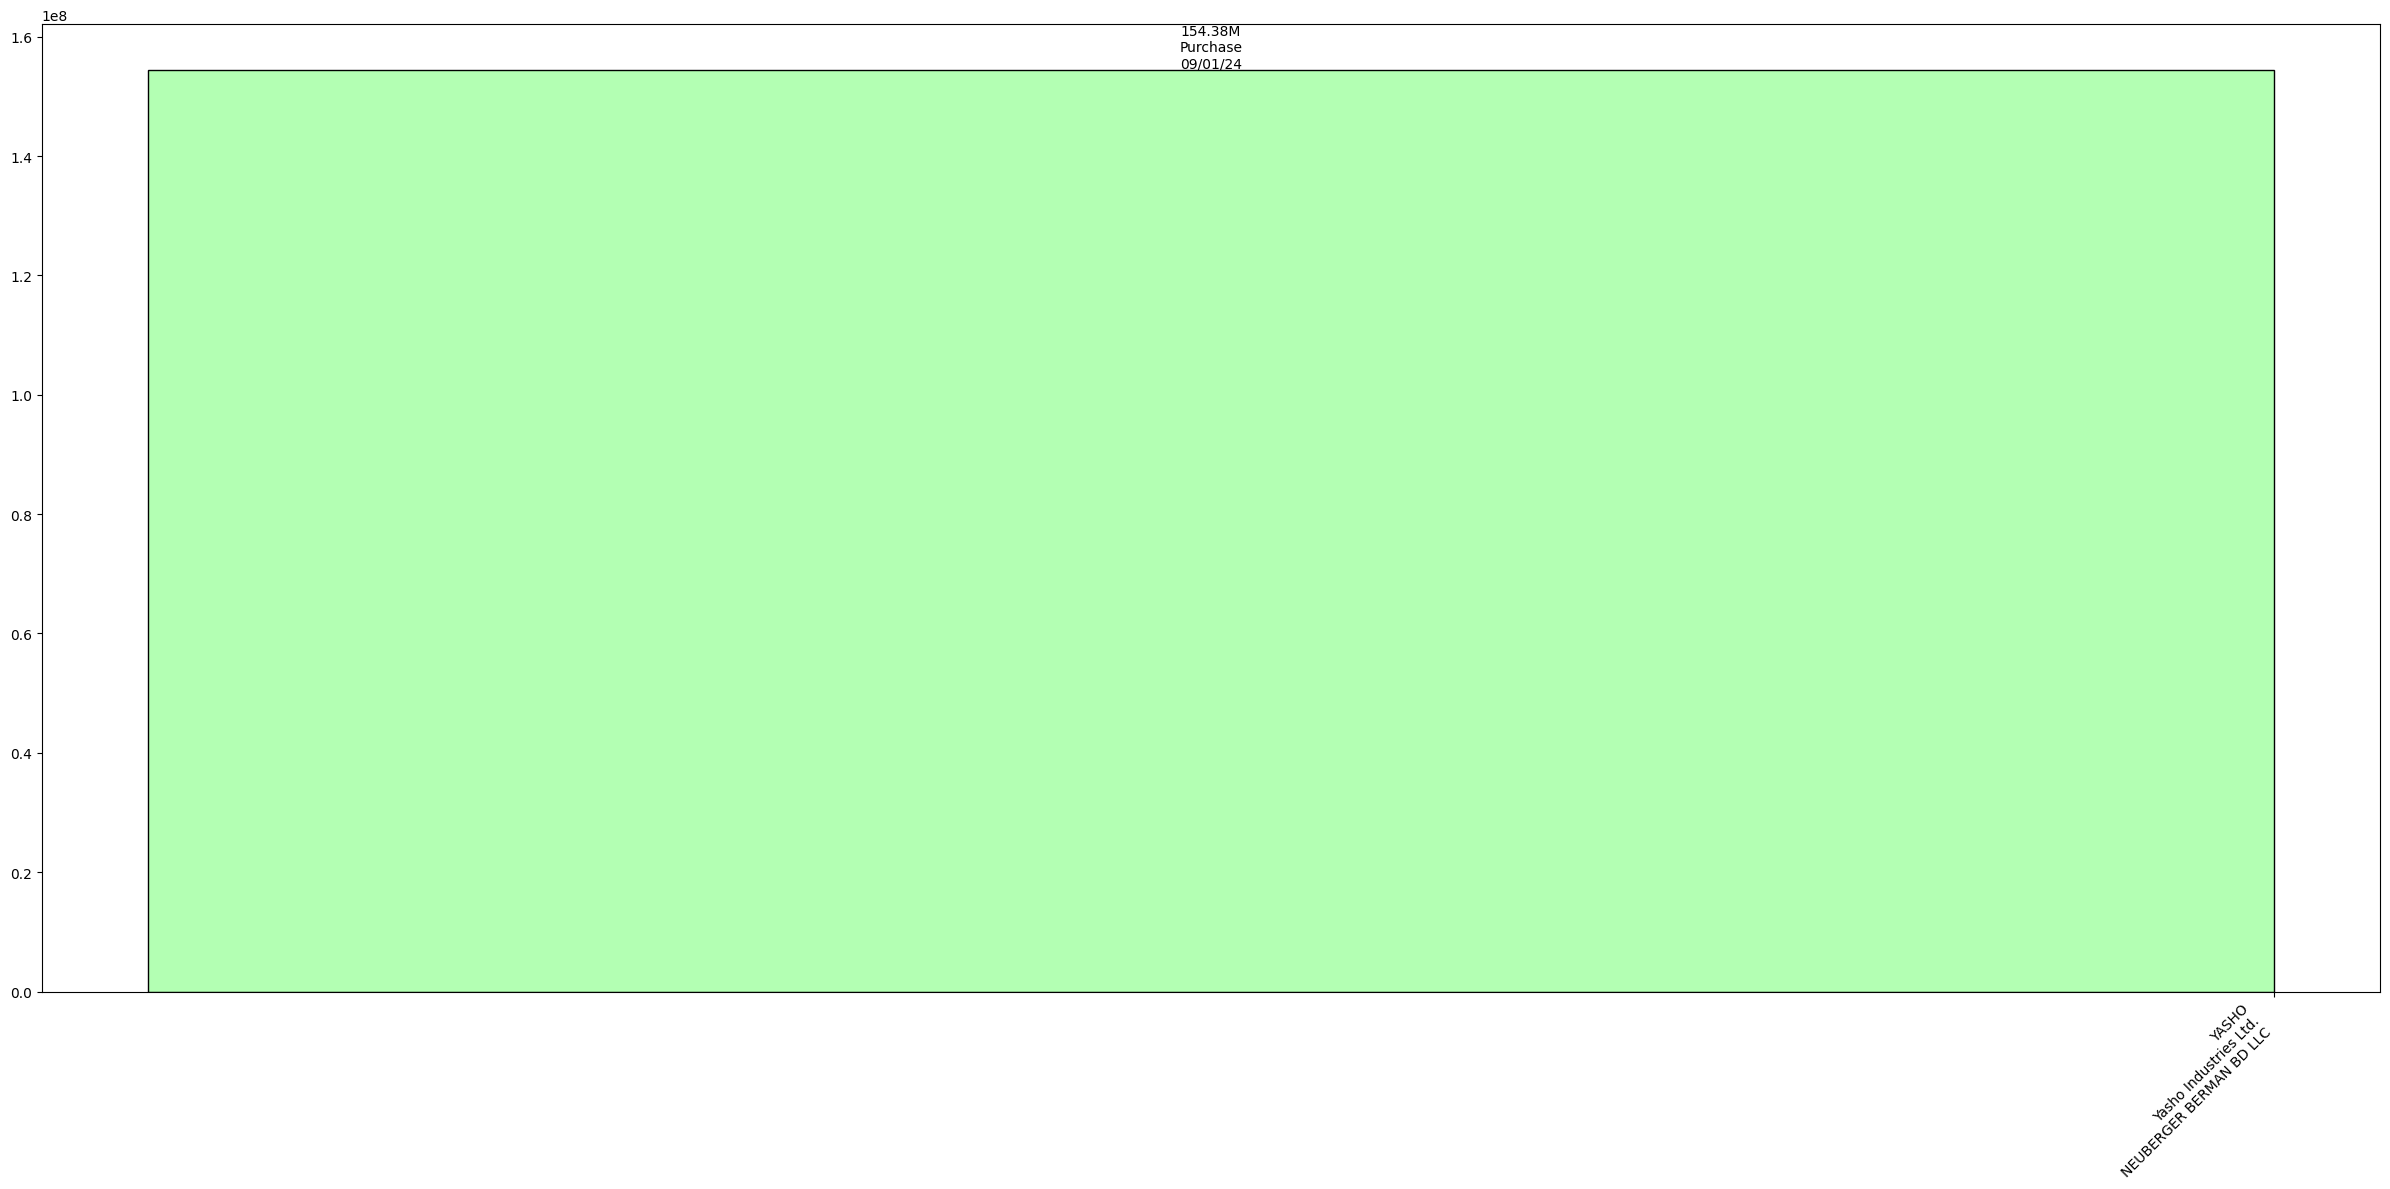


Sheet Name: Insider Disclosures
+----------------------------------------------------------+------------+----------------------------------------------------------+---------------------+-------------+----------------------+-----------+--------------------------+-----------------------+------------+-------------------------+---------------+--------------------+-------------------+-----------+
|                          Stock                           |    Code    |                       Client Name                        |   Client Category   |   Action    | Reported to Exchange | Quantity  | Post Transaction Holding |       Traded %        | Avg. Price |         Period          | Security Type |        Mode        | Last Traded Price | File Date |
+----------------------------------------------------------+------------+----------------------------------------------------------+---------------------+-------------+----------------------+-----------+--------------------------+-----------

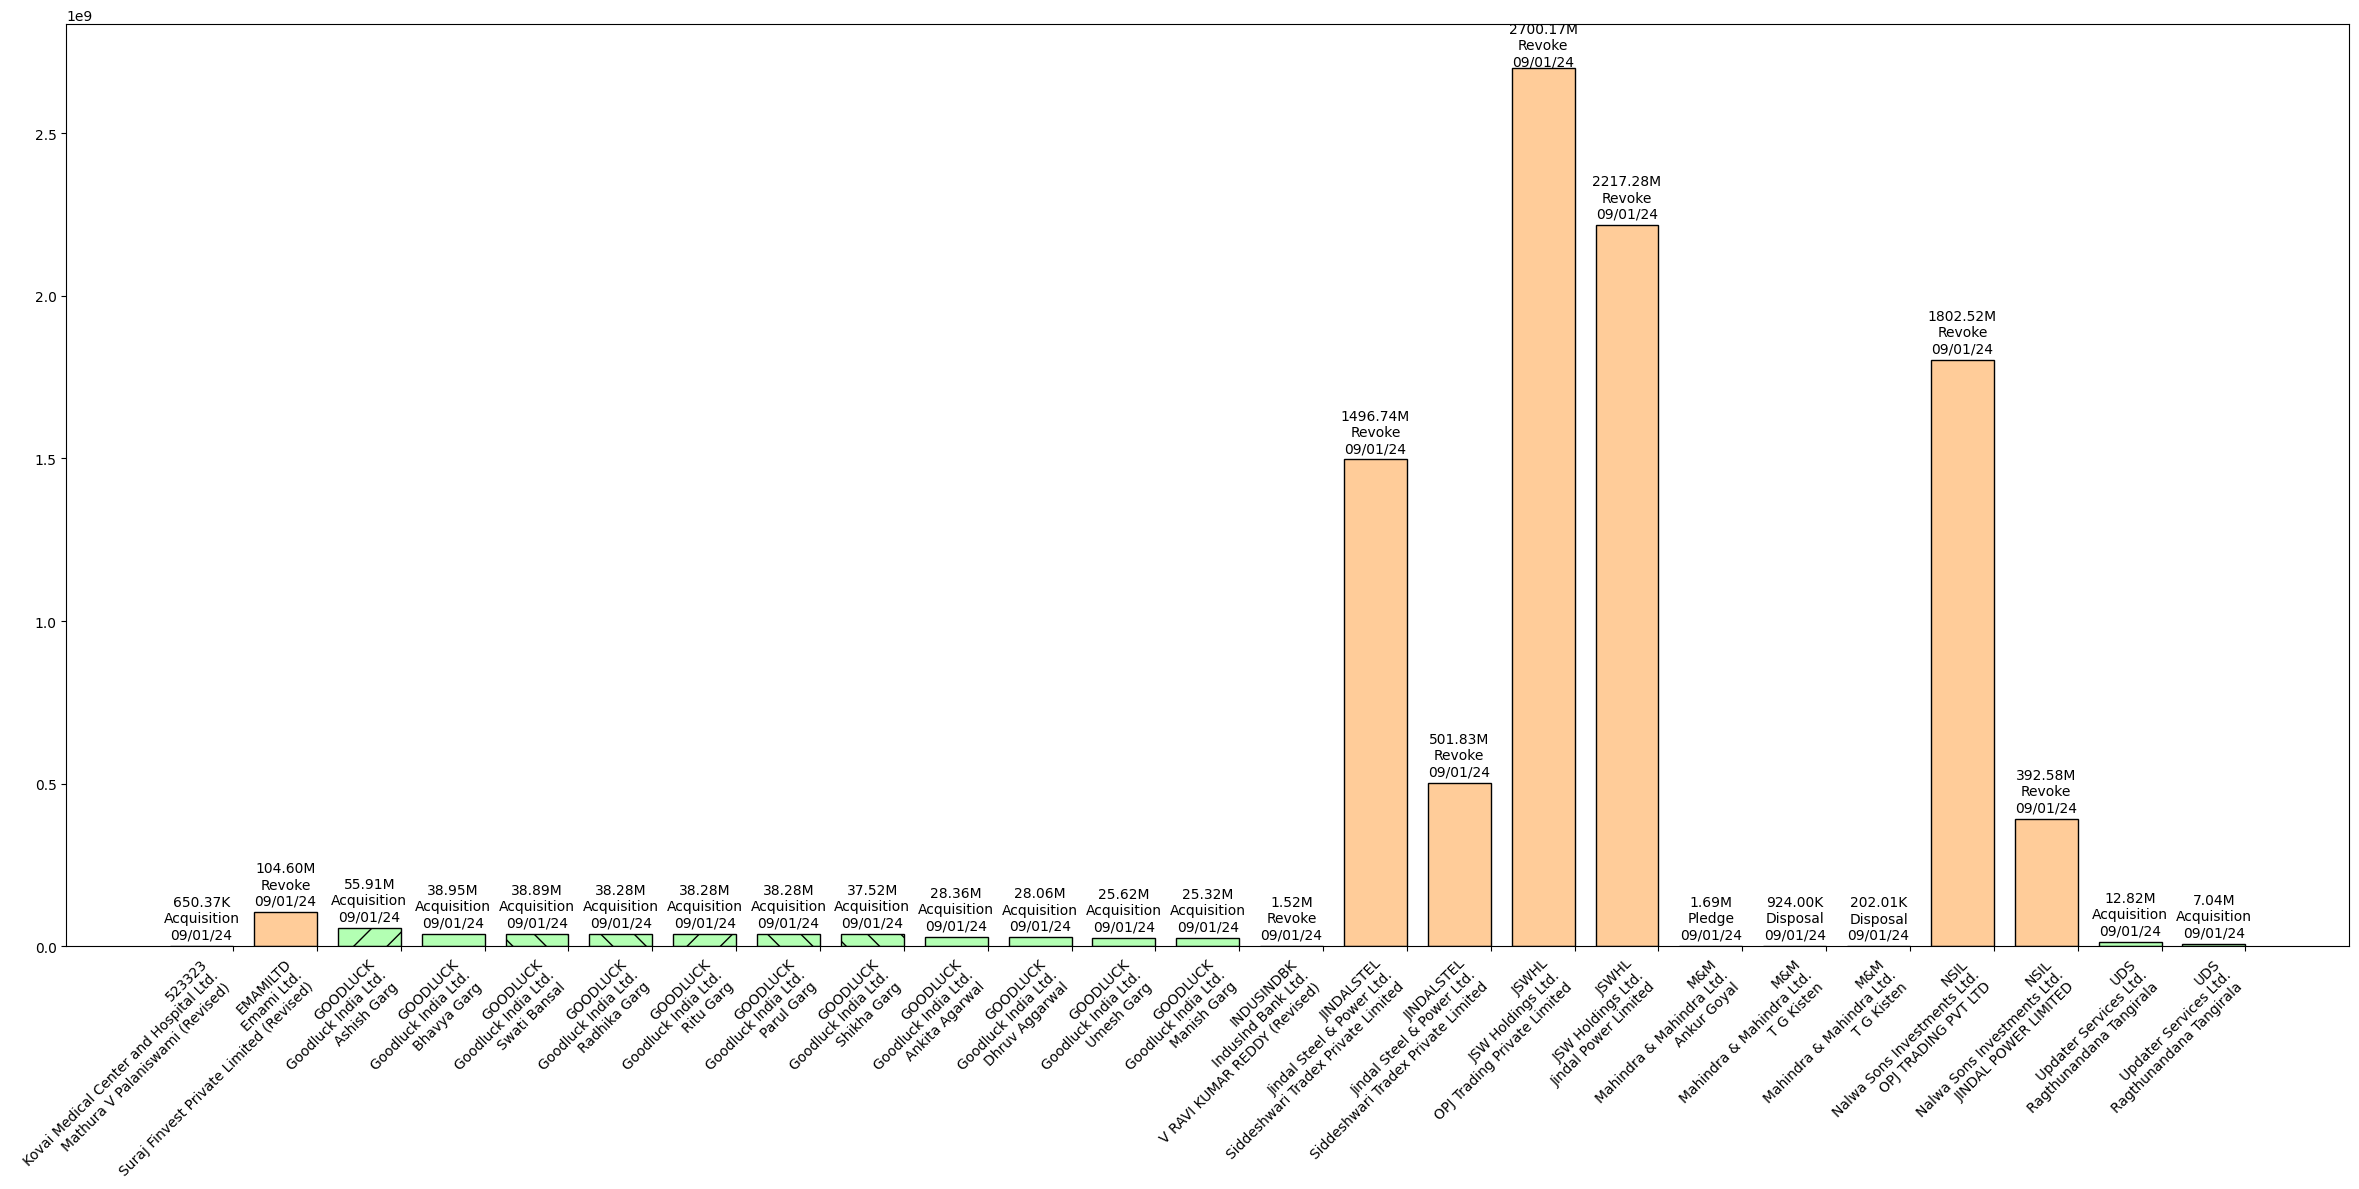

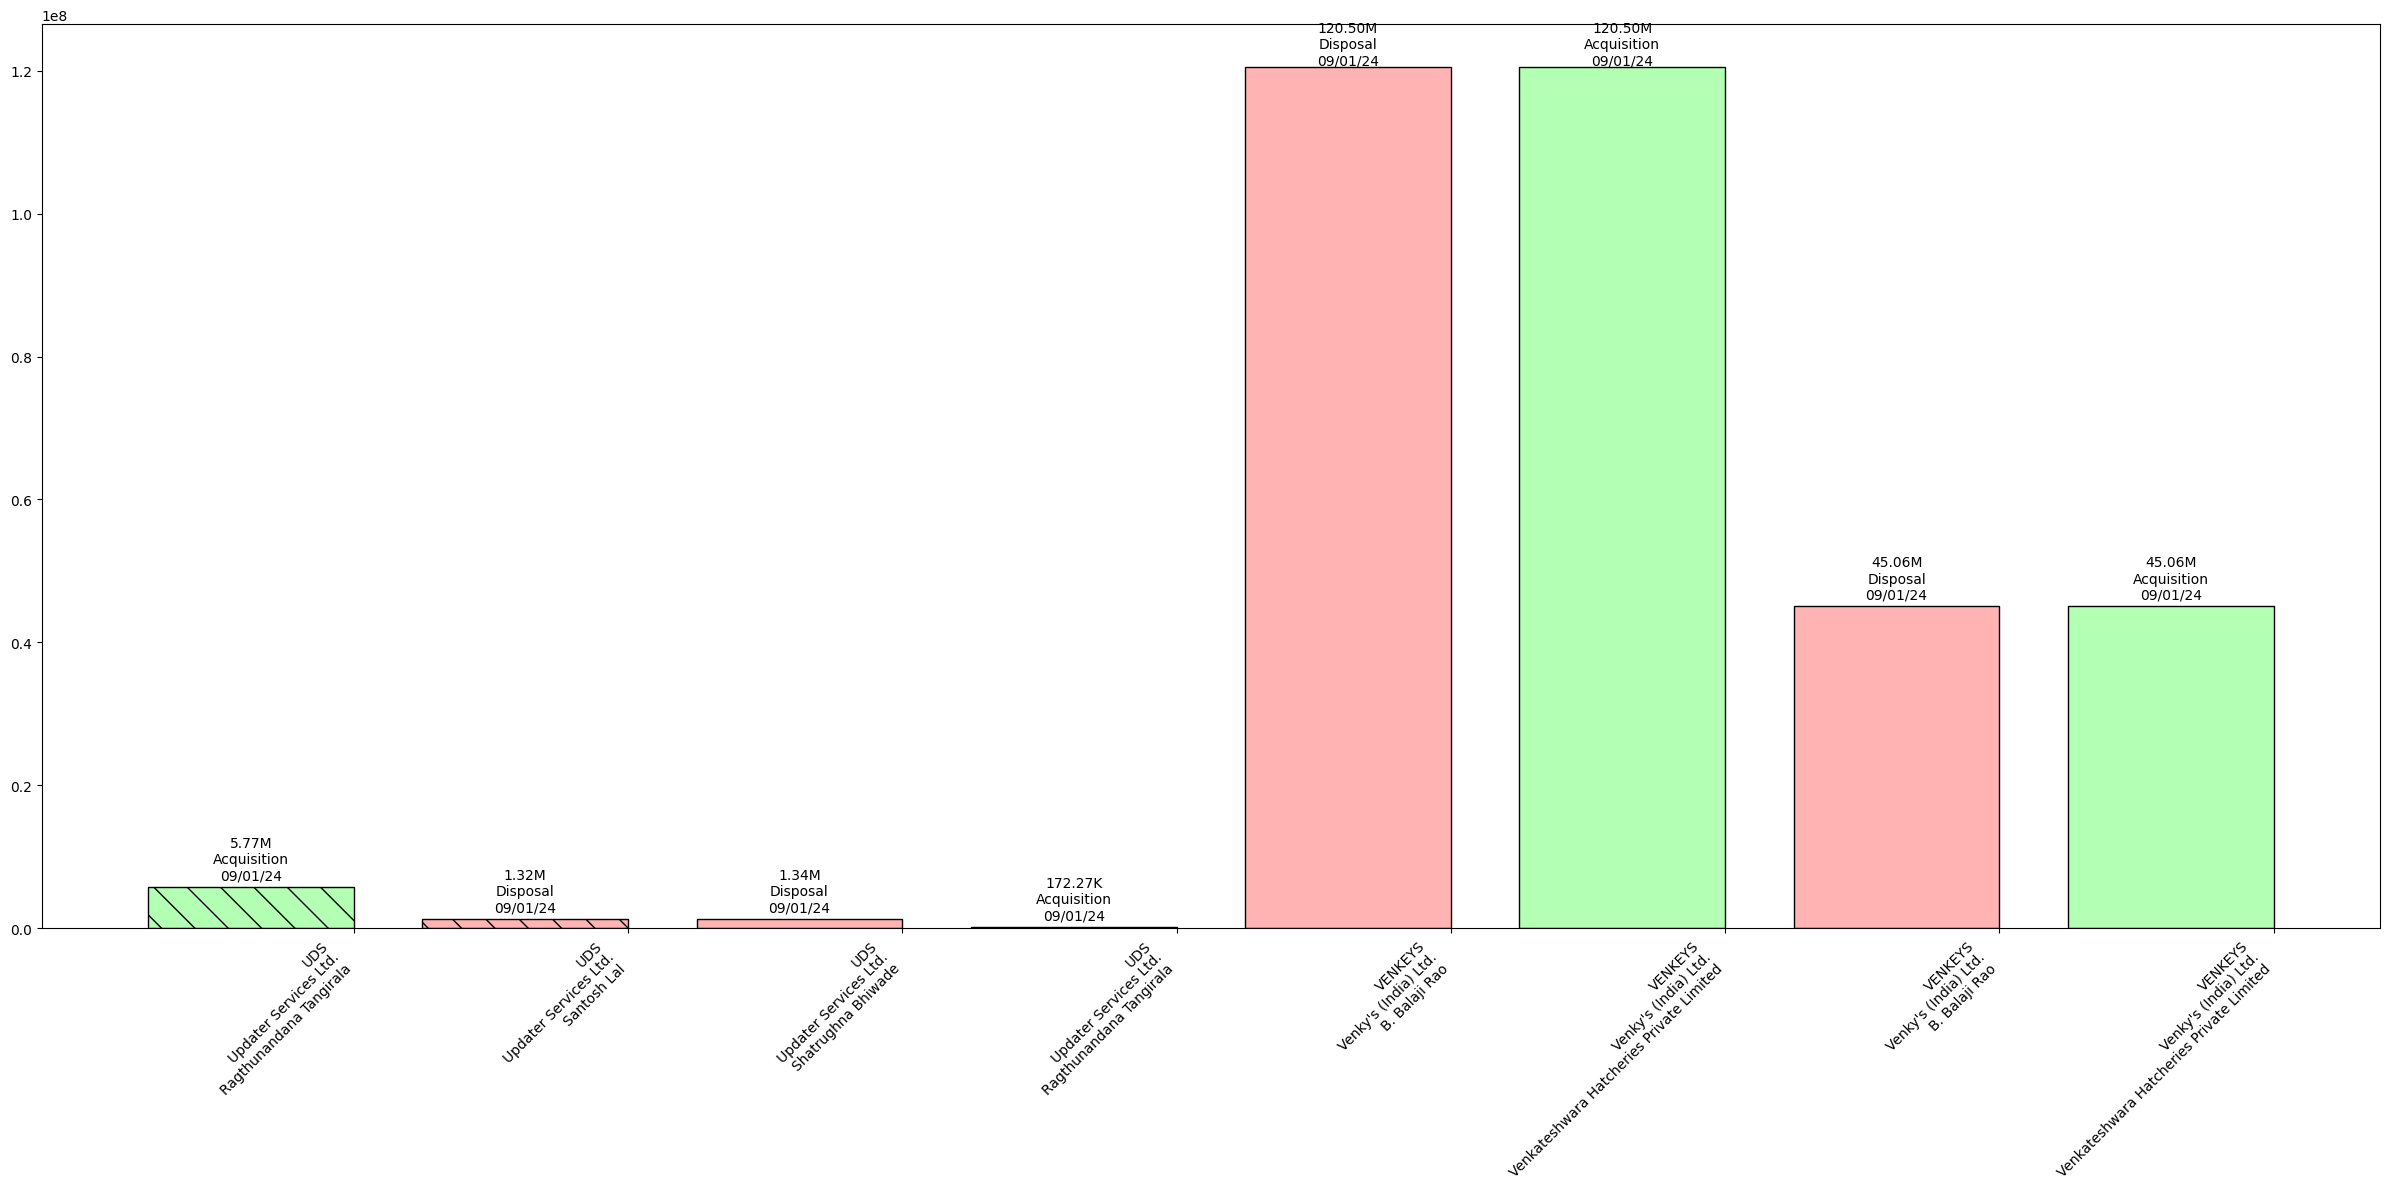

No special clients present.

Sheet Name: SAST-Significant Acquisitions
+--------------------------------------------------------------------------------------+------------+---------------------------------------------+-----------------+-------------+----------------------+------------+--------------------------+----------+-------------------------+-----------------+----------------------+-------------------+-----------+
|                                        Stock                                         |    Code    |                 Client Name                 | Client Category |   Action    | Reported to Exchange |  Quantity  | Post Transaction Holding | Traded % |         Period          | Regulation Type |         Mode         | Last Traded Price | File Date |
+--------------------------------------------------------------------------------------+------------+---------------------------------------------+-----------------+-------------+----------------------+------------+--------

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


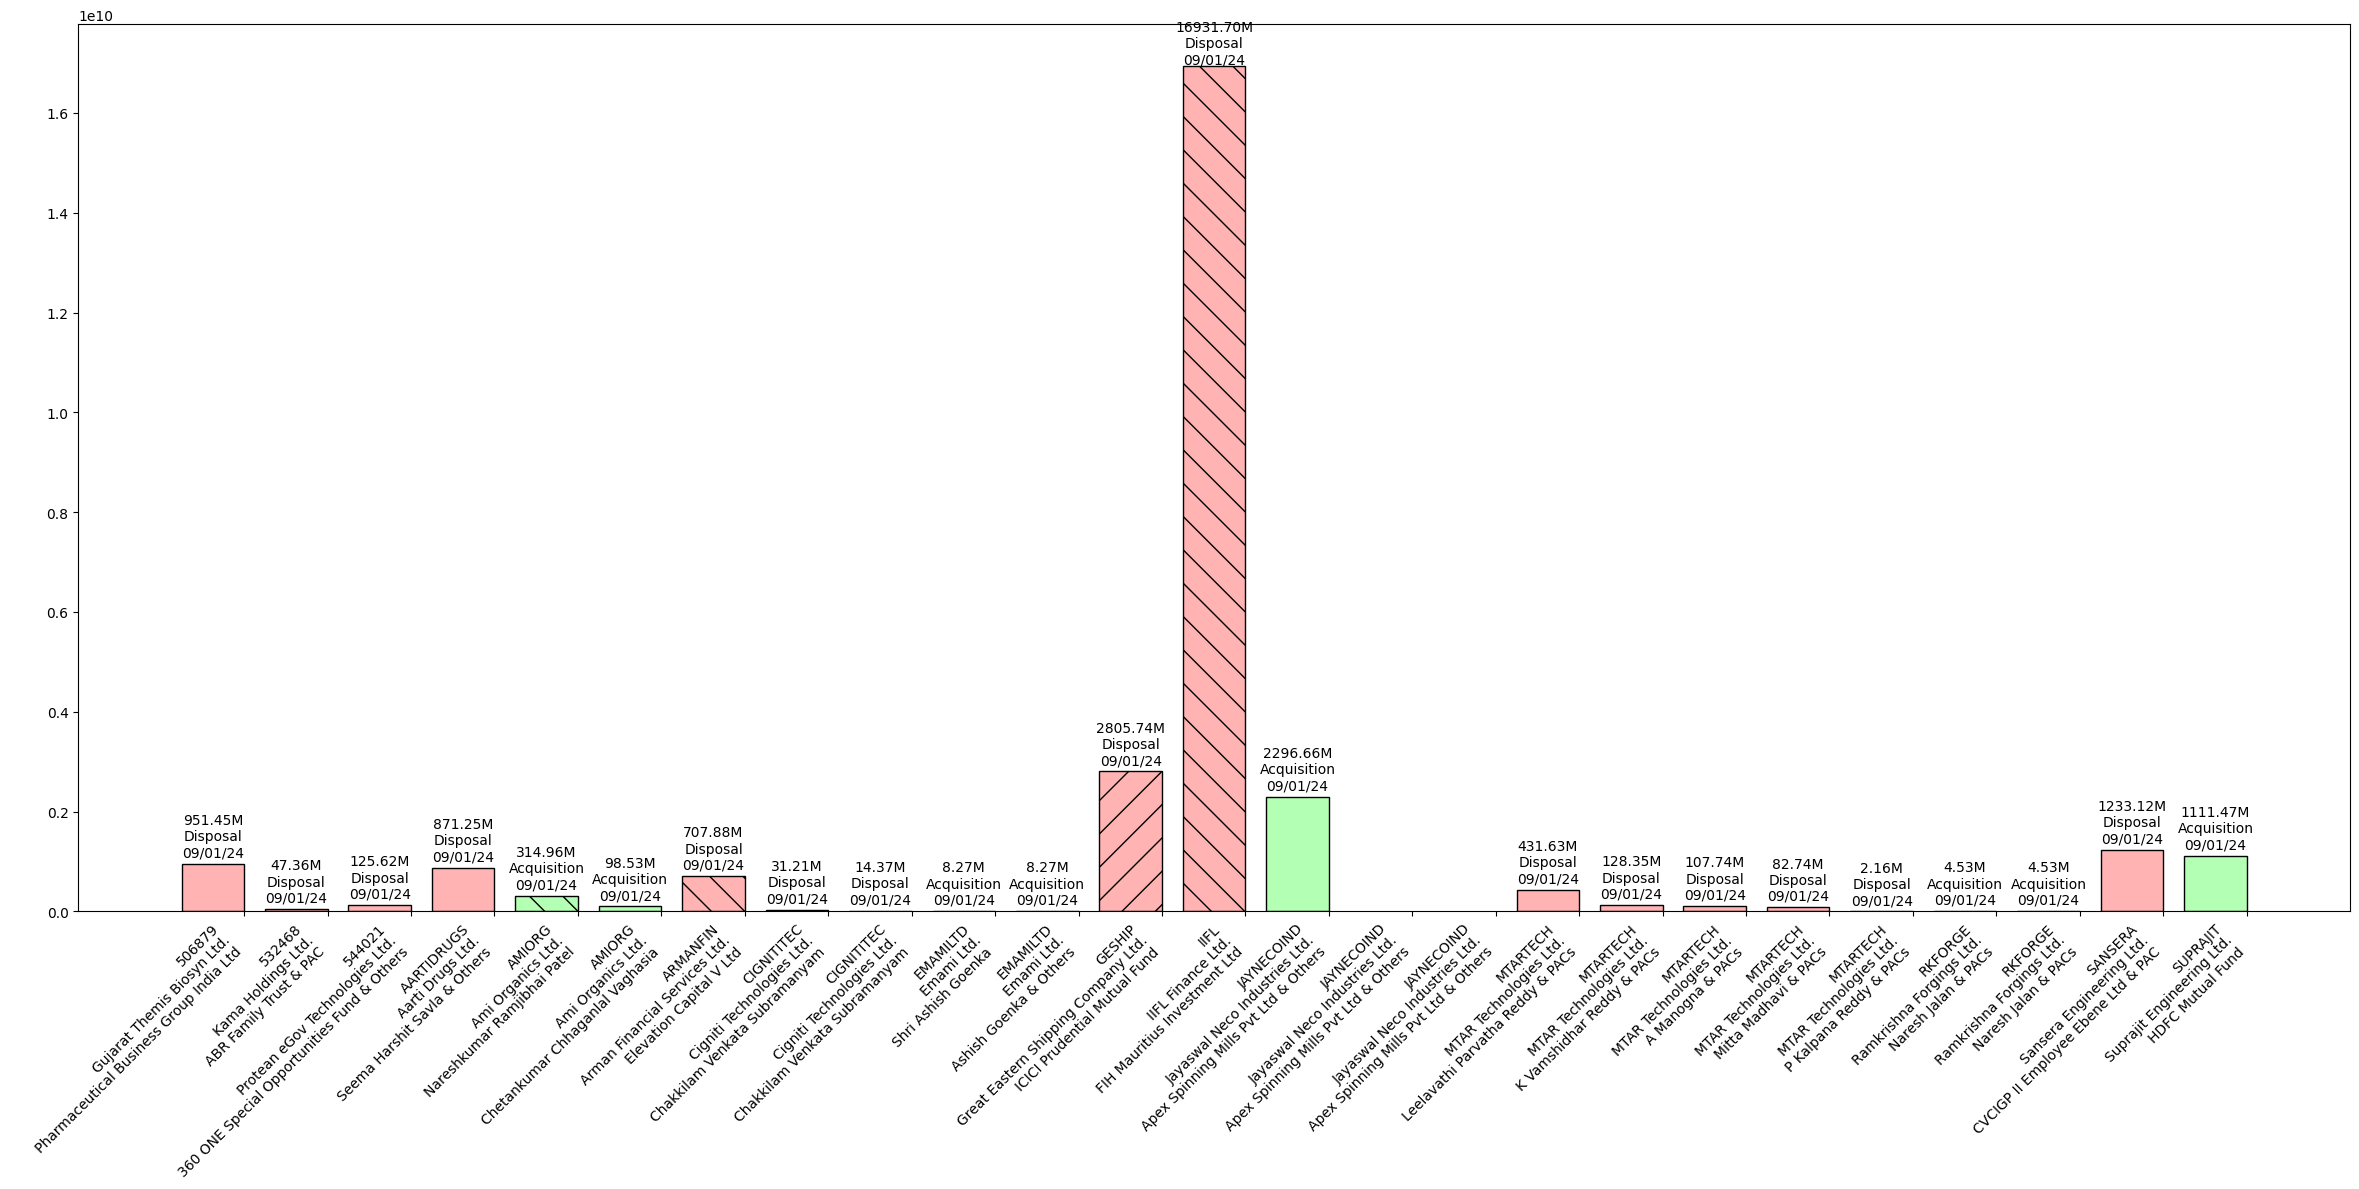

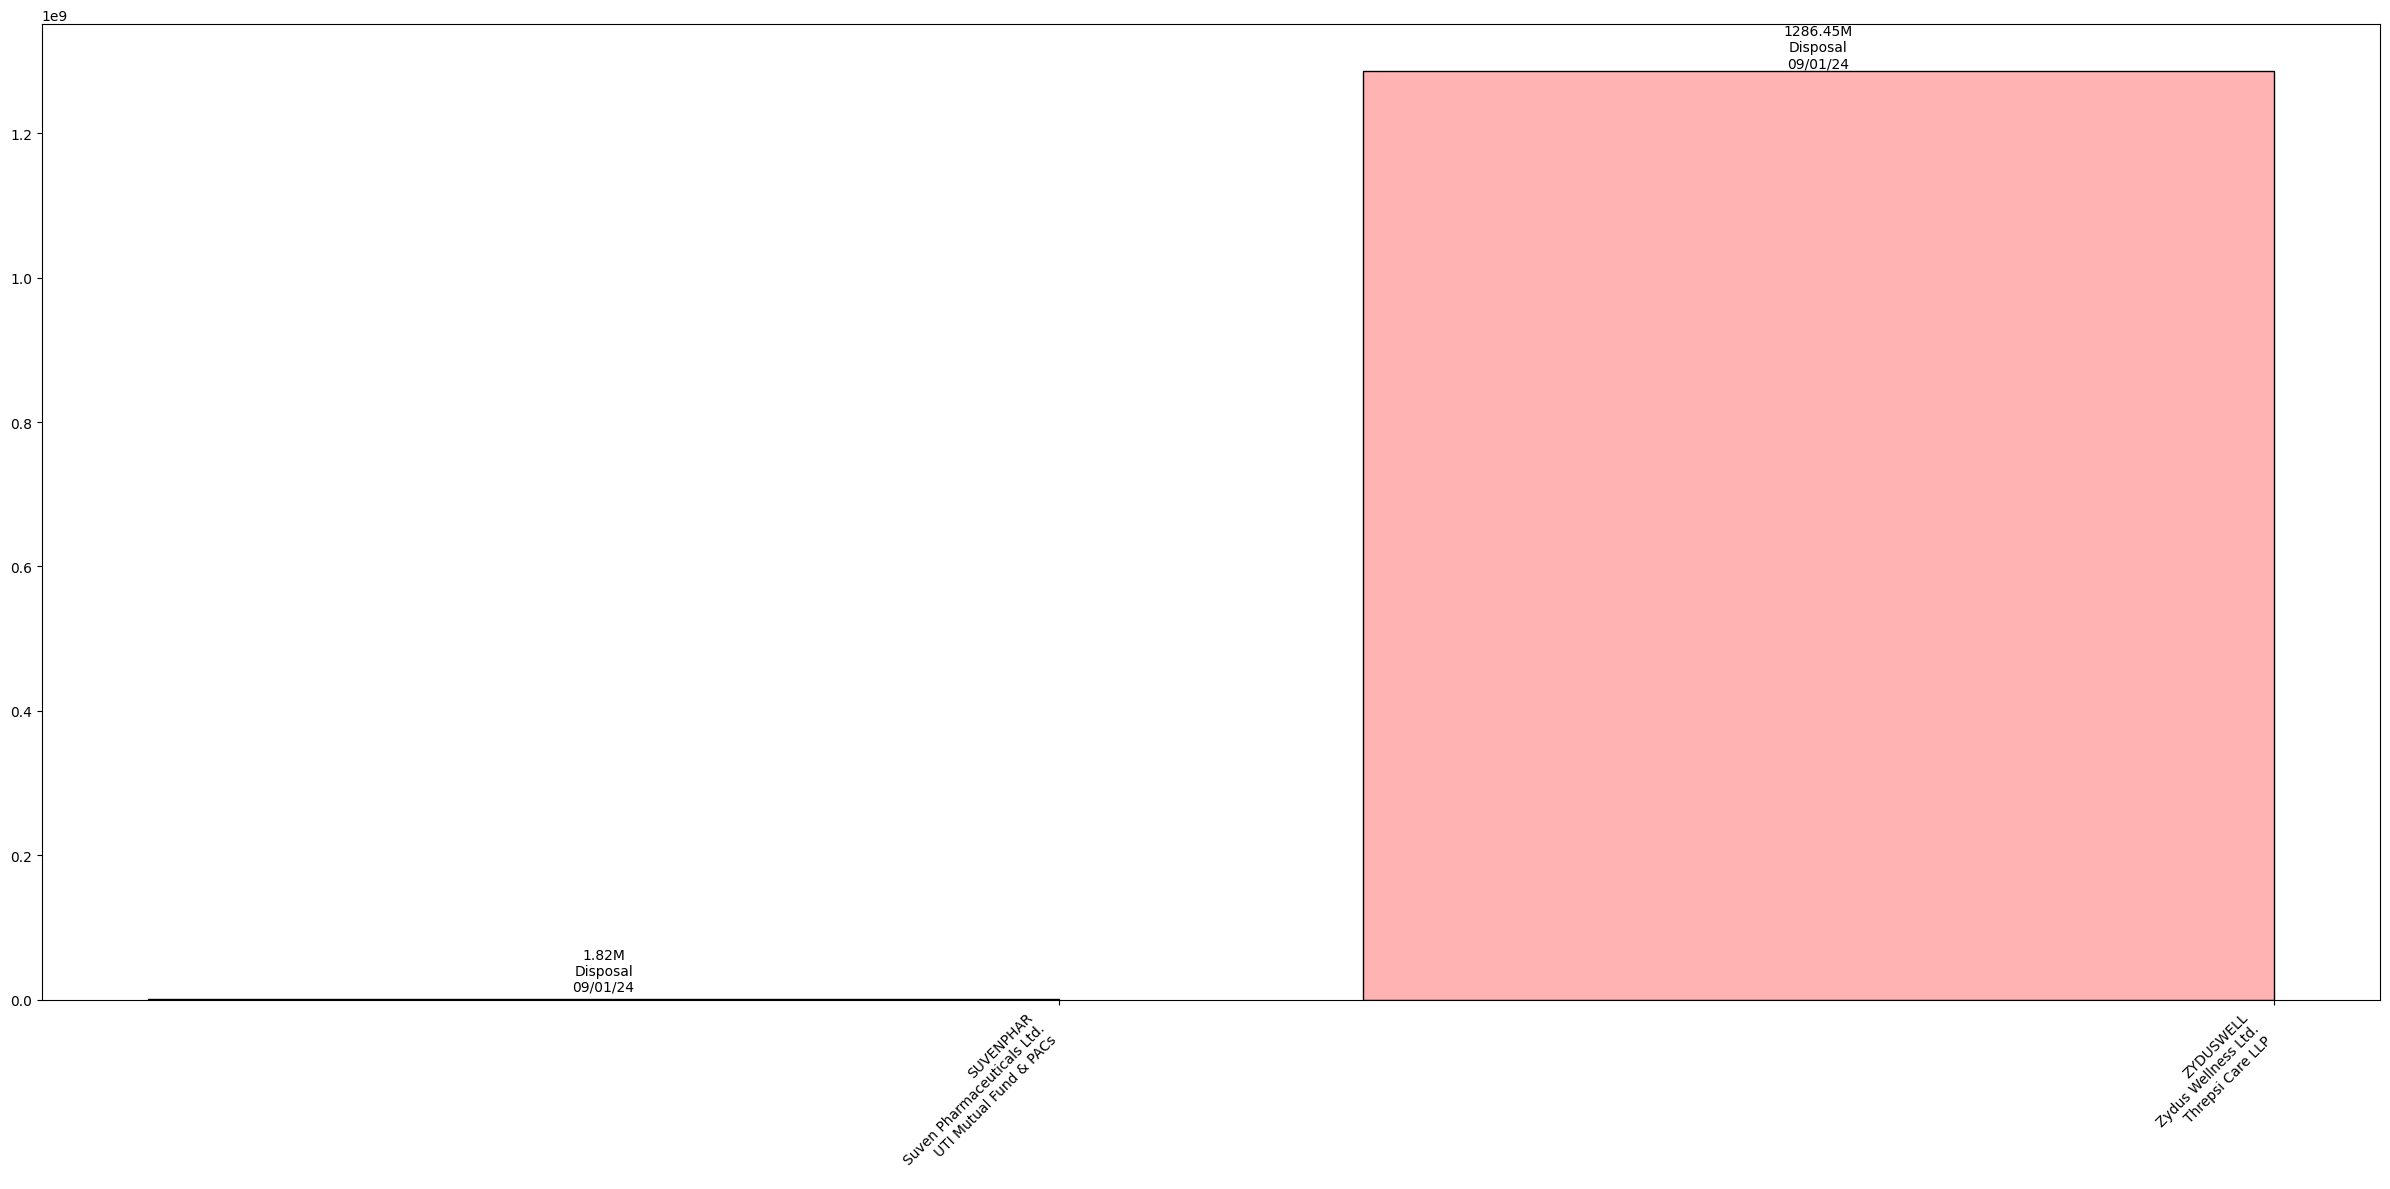

No special clients present.


In [69]:
import os
import pandas as pd
from tabulate import tabulate
import smtplib
from email.mime.text import MIMEText
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re


# Path to the Excel file with values to match
values_excel_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Scrip\Scrip090120241753.xlsx'

# Path to the folder with multiple Excel files
inbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Inbound'
outbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Outbound'

# Read values to match from the Excel file
values_df = pd.read_excel(values_excel_path)

# Extract the values from the relevant column (e.g., 'Scrip Code')
# values_to_match = values_df['Next 1000'].astype(str).str.lower().tolist()
values_to_match = values_df['Scrip Code'].astype(str).str.lower().tolist()

# Get a list of Excel files in the inbound folder
inbound_files = [os.path.join(inbound_folder_path, file) for file in os.listdir(inbound_folder_path) if file.endswith('.xlsx')]

# Your send_email function
def send_email(subject, body):
    # Configure email settings
    sender_email = "healthyplusrich@gmail.com"
    receiver_email = "akirabots@gmail.com"
    password = "password"

    # Create email message
    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = receiver_email

    # Send email
    try:
        # Send email
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login(sender_email, password)
            server.sendmail(sender_email, receiver_email, msg.as_string())
            print("Email sent successfully")
    except Exception as e:
        print(f"Error sending email: {e}")

def display_top_transactions_charts(unique_action_row, max_charts=10):
    # Calculate the total number of charts
    rows_per_chart = 25  # You can adjust the value based on your requirements

    total_charts = int(np.ceil(len(unique_action_row) / rows_per_chart))

    # Iterate through the data and display a maximum of three charts for each set of 25 rows
    for chart_num in range(min(total_charts, max_charts)):
        start_index = chart_num * rows_per_chart
        end_index = (chart_num + 1) * rows_per_chart
        subset_data = unique_action_row.iloc[start_index:end_index]

        # Create a bar chart with unique patterns for bars with the same code
        plt.figure(figsize=(24, 12))
        
        # Adjust the width and spacing between bars
        width = 0.6
        spacing = 0.2

        # Define colors based on action
        mild_green = '#b3ffb3'  # Mild green color
        mild_red = '#ffb3b3'    # Mild red color
        mild_orange = '#ffcc99'  # Mild orange color
        mild_yellow = '#ffffb3'  # Mild yellow color

        colors = [
            mild_green if (isinstance(action, str) and action.lower() in ['acquisition', 'purchase']) else
            mild_red if (isinstance(action, str) and action.lower() in ['sell', 'disposal']) else
            mild_orange if (isinstance(action, str) and action.lower() == 'revoke') else
            mild_yellow for action in subset_data['Action']
        ]

        bars = plt.bar(np.arange(len(subset_data)) * (width + spacing), subset_data['Amount'], width=width, color=colors, edgecolor='black')

        # Display the 'Code' and 'Client Name' on the x-axis
        x_labels = [
            f"{code}\n{stock}\n{name}" 
            for code, stock, name,  in zip(subset_data['Code'],subset_data['Stock'], subset_data['Client Name'])
        ]
        
        # Center the labels between bars
        plt.xticks(np.arange(len(subset_data)) * (width + spacing) + width / 2, x_labels, rotation=45, ha='right')

        # Display the formatted amount, action, and file date on top of each bar
        for bar, amount, action, file_date in zip(bars, subset_data['Amount'], subset_data['Action'], subset_data['File Date']):
            formatted_amount = f'{amount / 1_000:.2f}K' if amount < 1_000_000 else f'{amount / 1_000_000:.2f}M'
            formatted_file_date = datetime.strptime(file_date, '%Y%m%d').strftime('%d/%m/%y')
            # Adjust the position calculation to ensure finite values
            position = min(bar.get_height() + 0.005 * max(subset_data['Amount']), max(subset_data['Amount']))

            plt.text(bar.get_x() + bar.get_width() / 2, position,
                     f'{formatted_amount}\n{action}\n{formatted_file_date}', ha='center', va='bottom')

        # Add unique patterns for bars with the same code
        unique_codes = subset_data['Code'].unique()
        for code, bar in zip(unique_codes, bars):
            indices = np.where(subset_data['Code'] == code)[0]
            if len(indices) > 1:
                for i, index in enumerate(indices):
                    bar.set_hatch('/')
                    if i % 2 == 1:
                        bar.set_hatch('\\')

        # Show the chart
        plt.tight_layout()
        plt.show()

def process_data(process_df, price_col='Average Price', quantity_col='Quantity'):
    # Calculate 'Amount' column

    process_df = process_df.copy()
    process_df['Amount'] = process_df[price_col] * process_df[quantity_col]

    # Get unique action rows
    unique_action_rows = process_df.groupby(['File Date', 'Code', 'Client Name']).filter(lambda x: x['Action'].nunique() == 1)
    print("Only Buy or Sell:")
    print(tabulate(unique_action_rows, headers='keys', tablefmt='pretty', showindex=False))
    #Display Chart
    display_top_transactions_charts(unique_action_rows)

# Check if there are no files in the inbound folder
if not inbound_files:
    print("No files present in the inbound folder.")
else:
    # Dictionary to store results for each sheet name
    merged_results = {}

    # Iterate through each file
    for file_path in inbound_files:
        # Extract file date from the filename
        file_date = os.path.basename(file_path)[:8]

        # Read all sheets from the Excel file into a dictionary of DataFrames
        dfs = pd.read_excel(file_path, sheet_name=None)
        # Iterate through each sheet
        # print("values_to_match")
        # print(values_to_match)
        for sheet_name, df in dfs.items():
            # Convert the fourth column to lowercase and filter rows
            filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().isin(map(str.lower, values_to_match))]

            #filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().str.contains('|'.join(map(str.lower, values_to_match)))]
            #filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().str.contains(r'\b(?:' + '|'.join(map(re.escape, map(str.lower, values_to_match))) + r')\b')]
            # print(df.iloc[:, 3].astype(str).str.lower())
            # Drop the specified columns
            filtered_rows = filtered_rows.drop(columns=['Stock URL', 'ISIN', 'Stock Deals Page'])

            # Add a new column for file date
            filtered_rows['File Date'] = file_date

            # Check if the sheet name exists in the merged results dictionary
            if sheet_name not in merged_results:
                merged_results[sheet_name] = filtered_rows
            else:
                # Append the filtered rows to the existing sheet name
                merged_results[sheet_name] = pd.concat([merged_results[sheet_name], filtered_rows])
            


    # Display merged results
    for sheet_name, merged_df in merged_results.items():
        # Display the sheet name
        print(f"\nSheet Name: {sheet_name}")
    
        # Check if there are any rows in the merged result
        if not merged_df.empty:
            # Sort the result based on 'Code' and 'File Date'
            #sorted_rows = merged_df.sort_values(by=['Code', 'File Date'])
            sorted_rows = merged_df.sort_values(by=['File Date', 'Code'], ascending=[False, True])

            # Display the sorted rows in a tabular format
            print(tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False))

            # Calculate the new column by multiplying "Average Price" and "Quantity" for 'Bulk Block Deals'
            if sheet_name == 'Bulk Block Deals':
                   process_data(sorted_rows, price_col='Average Price', quantity_col='Quantity')
            if sheet_name == 'Insider Disclosures':
                   process_data(sorted_rows, price_col='Avg. Price', quantity_col='Quantity')
            if sheet_name == 'SAST-Significant Acquisitions':
                   process_data(sorted_rows, price_col='Last Traded Price', quantity_col='Quantity')



            # Read the second sheet named 'Client' from Scrip.xlsx
            client_sheet_df = pd.read_excel(values_excel_path, sheet_name='Client', header=None, skiprows=1)
            clients_info = client_sheet_df.iloc[:, :2].rename(columns={0: 'Client Code', 1: 'Client Name'})
            clients_info['Client Code'] = clients_info['Client Code'].astype(str).str.lower()
    
            # Filter rows in sorted_rows where 'Client Name' partially matches 'Client Code' list
            special_clients = sorted_rows[sorted_rows['Client Name'].astype(str).str.lower().str.contains('|'.join(clients_info['Client Code'].tolist()), na=False)]
    
            # Send email with the result
            email_subject = f"Results for {sheet_name}"
            email_body = tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False)
            #send_email(email_subject, email_body)
    
            # # Move the file to the outbound folder after processing all sheets
            # outbound_file_path = os.path.join(outbound_folder_path, os.path.basename(file_path))
            # os.rename(file_path, outbound_file_path)
            # print(f"File moved to: {outbound_file_path}")
            
            # Display special clients in a separate tabular format
            if not special_clients.empty:
                print("\nSpecial Clients:")
                # print(tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False))

                # Calculate the new column by multiplying "Average Price" and "Quantity" for 'Bulk Block Deals'
                if sheet_name == 'Bulk Block Deals':
                       process_data(special_clients, price_col='Average Price', quantity_col='Quantity')
                if sheet_name == 'Insider Disclosures':
                       process_data(special_clients, price_col='Avg. Price', quantity_col='Quantity')
                if sheet_name == 'SAST-Significant Acquisitions':
                       process_data(special_clients, price_col='Last Traded Price', quantity_col='Quantity')

                
                email_subject = f"Results for Special Client {sheet_name}"
                email_body = tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False)
                #send_email(email_subject, email_body)
                
            else:
                print("No special clients present.")
        else:
            print("No data present.")

In [ ]:
Automated Daily Deal with Special Client without email client 

In [ ]:
import os
import pandas as pd
from tabulate import tabulate
import smtplib
from email.mime.text import MIMEText

# Your send_email function
def send_email(subject, body):
    # Configure email settings
    sender_email = "healthyplusrich@gmail.com"
    receiver_email = "akirabots@gmail.com"
    password = "password"

    # Create email message
    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = receiver_email

    # Send email
    try:
        # Send email
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login(sender_email, password)
            server.sendmail(sender_email, receiver_email, msg.as_string())
            print("Email sent successfully")
    except Exception as e:
        print(f"Error sending email: {e}")


# Path to the Excel file with values to match
values_excel_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Scrip\Scrip050120242024.xlsx'

# Path to the folder with multiple Excel files
inbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Inbound'
outbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Outbound'

# Read values to match from the Excel file
values_df = pd.read_excel(values_excel_path)

# Extract the values from the relevant column (e.g., 'Scrip Code')
values_to_match = values_df['Scrip Code'].astype(str).str.lower().tolist()

# Get a list of Excel files in the inbound folder
inbound_files = [os.path.join(inbound_folder_path, file) for file in os.listdir(inbound_folder_path) if file.endswith('.xlsx')]

# Check if there are no files in the inbound folder
if not inbound_files:
    print("No files present in the inbound folder.")
else:
    # Dictionary to store results for each sheet name
    merged_results = {}

    # Iterate through each file
    for file_path in inbound_files:
        # Extract file date from the filename
        file_date = os.path.basename(file_path)[:8]

        # Read all sheets from the Excel file into a dictionary of DataFrames
        dfs = pd.read_excel(file_path, sheet_name=None)

        # Iterate through each sheet
        for sheet_name, df in dfs.items():
            # Convert the fourth column to lowercase and filter rows
            filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().isin(map(str.lower, values_to_match))]

            # Drop the specified columns
            filtered_rows = filtered_rows.drop(columns=['Stock URL', 'ISIN', 'Stock Deals Page'])

            # Add a new column for file date
            filtered_rows['File Date'] = file_date

            # Check if the sheet name exists in the merged results dictionary
            if sheet_name not in merged_results:
                merged_results[sheet_name] = filtered_rows
            else:
                # Append the filtered rows to the existing sheet name
                merged_results[sheet_name] = pd.concat([merged_results[sheet_name], filtered_rows])
        # try:
        #     if os.path.exists(file_path):
        #         outbound_file_path = os.path.join(outbound_folder_path, os.path.basename(file_path))
                
        #         # Attempt to move the file
        #         os.rename(file_path, outbound_file_path)
        #         print(f"File moved to: {outbound_file_path}")
        #     else:
        #         print(f"Error: File not found at: {file_path}")
        # except Exception as e:
        #     print(f"Error occurred while moving the file: {e}")
          

    # Display merged results
    for sheet_name, merged_df in merged_results.items():
        # Display the sheet name
        print(f"\nSheet Name: {sheet_name}")
    
        # Check if there are any rows in the merged result
        if not merged_df.empty:
            # Sort the result based on 'Code' and 'File Date'

            sorted_rows = merged_df.sort_values(by=['File Date', 'Code'], ascending=[False, True])
            
    
            # Display the sorted rows in a tabular format
            print(tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False))
            

    
            # Read the second sheet named 'Client' from Scrip.xlsx
            client_sheet_df = pd.read_excel(values_excel_path, sheet_name='Client', header=None, skiprows=1)
            clients_info = client_sheet_df.iloc[:, :2].rename(columns={0: 'Client Code', 1: 'Client Name'})
            clients_info['Client Code'] = clients_info['Client Code'].astype(str).str.lower()
    
            # Filter rows in sorted_rows where 'Client Name' partially matches 'Client Code' list
            special_clients = sorted_rows[sorted_rows['Client Name'].astype(str).str.lower().str.contains('|'.join(clients_info['Client Code'].tolist()), na=False)]
    
            # Send email with the result
            email_subject = f"Results for {sheet_name}"
            email_body = tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False)
            #send_email(email_subject, email_body)

            
            # Display special clients in a separate tabular format
            if not special_clients.empty:
                print("\nSpecial Clients:")
                print(tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False))
    
                email_subject = f"Results for Special Client {sheet_name}"
                email_body = tabulate(special_clients, headers='keys', tablefmt='pretty', showindex=False)
                #send_email(email_subject, email_body)
                
            else:
                print("No special clients present.")
        else:
            print("No data present.")

        # Move the file to the outbound folder after processing all sheets

   
 

In [ ]:
Automated Daily Deal with email client

In [ ]:
import os
import pandas as pd
from tabulate import tabulate
import smtplib
from email.mime.text import MIMEText

# Your send_email function
def send_email(subject, body):
    # Configure email settings
    sender_email = "healthyplusrich@gmail.com"
    receiver_email = "akirabots@gmail.com"
    password = "password"

    # Create email message
    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = receiver_email

    # Send email
    try:
        # Send email
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login(sender_email, password)
            server.sendmail(sender_email, receiver_email, msg.as_string())
            print("Email sent successfully")
    except Exception as e:
        print(f"Error sending email: {e}")

# Path to the Excel file with values to match
values_excel_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Scrip\Scrip05012024.xlsx'

# Path to the folder with multiple Excel files
inbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Inbound'
outbound_folder_path = r'C:\Users\91908\Documents\Raja\Share market\Analysis\Trendlyne\Data\Outbound'

# Read values to match from the Excel file
values_df = pd.read_excel(values_excel_path)

# Extract the values from the relevant column (e.g., 'Scrip Code')
values_to_match = values_df['Scrip Code'].astype(str).str.lower().tolist()

# Get a list of Excel files in the inbound folder
inbound_files = [os.path.join(inbound_folder_path, file) for file in os.listdir(inbound_folder_path) if file.endswith('.xlsx')]

# Check if there are no files in the inbound folder
if not inbound_files:
    print("No files present in the inbound folder.")
else:
    # Dictionary to store results for each sheet name
    merged_results = {}

    # Iterate through each file
    for file_path in inbound_files:
        # Extract file date from the filename
        file_date = os.path.basename(file_path)[:8]

        # Read all sheets from the Excel file into a dictionary of DataFrames
        dfs = pd.read_excel(file_path, sheet_name=None)

        # Iterate through each sheet
        for sheet_name, df in dfs.items():
            # Convert the fourth column to lowercase and filter rows
            filtered_rows = df[df.iloc[:, 3].astype(str).str.lower().isin(map(str.lower, values_to_match))]

            # Drop the specified columns
            filtered_rows = filtered_rows.drop(columns=['Stock URL', 'ISIN', 'Stock Deals Page'])

            # Add a new column for file date
            filtered_rows['File Date'] = file_date

            # Check if the sheet name exists in the merged results dictionary
            if sheet_name not in merged_results:
                merged_results[sheet_name] = filtered_rows
            else:
                # Append the filtered rows to the existing sheet name
                merged_results[sheet_name] = pd.concat([merged_results[sheet_name], filtered_rows])

        # Move the file to the outbound folder after processing all sheets
        outbound_file_path = os.path.join(outbound_folder_path, os.path.basename(file_path))
        os.rename(file_path, outbound_file_path)
        print(f"File moved to: {outbound_file_path}")

    # Check if there are any results
    if any(merged_results):
        # Display merged results
        for sheet_name, merged_df in merged_results.items():
            # Display the sheet name
            print(f"\nSheet Name: {sheet_name}")

            # Check if there are any rows in the merged result
            if not merged_df.empty:
                # Sort the result based on 'Code' and 'File Date'
                #sorted_rows = merged_df.sort_values(by=['Code', 'File Date'])
                sorted_rows = merged_df.sort_values(by=['File Date', 'Code'], ascending=[False, True])
    
                # Display the sorted rows in a tabular format
                print(tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False))

                # Send email with the result
                email_subject = f"Results for {sheet_name}"
                email_body = tabulate(sorted_rows, headers='keys', tablefmt='pretty', showindex=False)
                send_email(email_subject, email_body)
            else:
                print("No data present.")
    else:
        print("No results found.")
